#Predictive Analytics in Judicial Decision-Making: A Focus on Supreme Court Rulings

Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import nltk
import re

Loading data into a dataframe

In [ ]:
df = pd.read_csv('/content/justice.csv', delimiter=',', encoding = "utf8")
df.dropna(inplace=True)
df.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3098 entries, 1 to 3302
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          3098 non-null   int64 
 1   ID                  3098 non-null   int64 
 2   name                3098 non-null   object
 3   href                3098 non-null   object
 4   docket              3098 non-null   object
 5   term                3098 non-null   object
 6   first_party         3098 non-null   object
 7   second_party        3098 non-null   object
 8   facts               3098 non-null   object
 9   facts_len           3098 non-null   int64 
 10  majority_vote       3098 non-null   int64 
 11  minority_vote       3098 non-null   int64 
 12  first_party_winner  3098 non-null   object
 13  decision_type       3098 non-null   object
 14  disposition         3098 non-null   object
 15  issue_area          3098 non-null   object
dtypes: int64(5), object(11)
memor

Dropping irrelevant columns

In [ ]:
df1 = df.copy()

In [ ]:
df1.drop(columns=['Unnamed: 0', 'docket','name','first_party','second_party', 'issue_area',
                 'facts_len', 'majority_vote', 'minority_vote', 'href', 'ID','term'], inplace=True)

In [ ]:
df1.columns

Index(['facts', 'first_party_winner', 'decision_type', 'disposition'], dtype='object')

Dividing preprocessing tasks in 6 steps

In [ ]:
df_cat = df1[['decision_type', 'disposition']]

In [ ]:
df_target = df1['first_party_winner']

In [ ]:
df_nlp = df1['facts']

In [ ]:
# Resetting indices to avoid NaNs during concatenation
df_cat.reset_index(drop=True, inplace=True)
df_target.reset_index(drop=True, inplace=True)
df_nlp.reset_index(drop=True, inplace=True)

Step 1: Performing one-hot encoding on Target

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df_target= label_encoder.fit_transform(df_target)

In [ ]:
df_target1 = pd.DataFrame(df_target, columns=['first_party_winner'])
df_target1

,first_party_winner
0,1
1,1
2,1
3,1
4,1
...,...
3093,1
3094,1
3095,0
3096,1


Step 2: Performing initial cleaning and tokenizing the corpus (*facts* column), introducing a function to perform further cleaning and Lemmatization upon the data.

In [ ]:
df_nlp1 = pd.DataFrame(df_nlp, columns=['facts'])

In [ ]:
df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True)
df_nlp1

,facts
0,Joan Stanley had three children with Peter Sta...
1,John Giglio was convicted of passing forged mo...
2,"The Idaho Probate Code specified that ""males m..."
3,"Miller, after conducting a mass mailing campai..."
4,Ernest E. Mandel was a Belgian professional jo...
...,...
3093,For over a century after the Alaska Purchase i...
3094,"Refugio Palomar-Santiago, a Mexican national, ..."
3095,Tarahrick Terry pleaded guilty to one count of...
3096,Joshua James Cooley was parked in his pickup t...


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def utils_preprocess_text(text, flg_lemm=True, lst_stopwords=None):
    ## clean
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    ## Tokenize
    lst_text = text.split()

    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    ## Lemmatisation
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
df_nlp1["facts_clean"] = df_nlp1["facts"].apply(lambda x: utils_preprocess_text(x, flg_lemm=True, lst_stopwords=lst_stopwords))

In [ ]:
df_nlp1

,facts,facts_clean
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...
...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...


Step 3: Concatenating target with facts

In [ ]:
df_nlp2 = pd.concat([df_nlp1,df_target1['first_party_winner']],axis=1, join='inner')
df_nlp2

,facts,facts_clean,first_party_winner
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1
...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,1
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,1
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,0
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,1


Analysing Unigrams and Bigrams for both first party and second party winners separately

In [ ]:
df_nlp2["first_party_winner"].value_counts()

first_party_winner
1    2067
0    1031
Name: count, dtype: int64

In [ ]:
from matplotlib.pyplot import figure

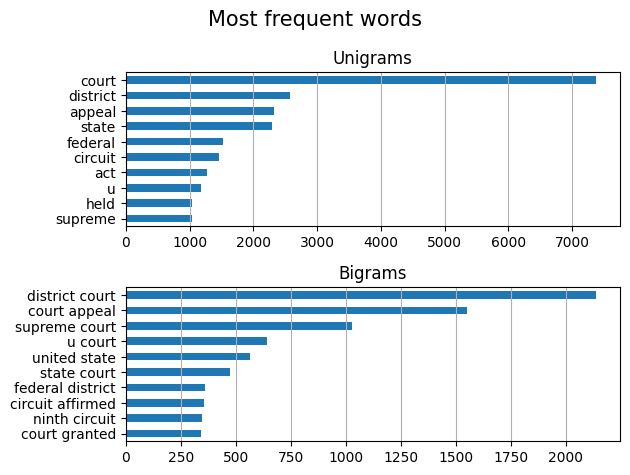

In [ ]:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)

## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(),
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0],
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)

## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(),
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.tight_layout()
plt.show()

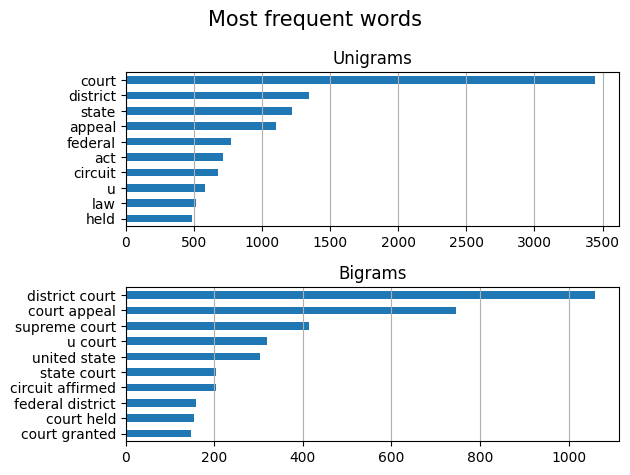

In [ ]:
y = 0
corpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)

## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(),
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0],
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)

## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(),
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.tight_layout()
plt.show()

Step 4: Concatenating the target+facts with the rest of the columns


In [ ]:
df_nl1=pd.concat([df_nlp2,df_cat],axis=1,join='inner')

In [ ]:
df_nl1

,facts,facts_clean,first_party_winner,decision_type,disposition
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1,majority opinion,reversed/remanded
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1,majority opinion,reversed/remanded
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1,majority opinion,reversed/remanded
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1,majority opinion,vacated/remanded
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1,majority opinion,reversed
...,...,...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,1,majority opinion,reversed/remanded
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,1,majority opinion,reversed/remanded
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,0,majority opinion,affirmed
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,1,majority opinion,vacated/remanded


In [ ]:
xfeatures1 = df_nl1[['facts_clean','decision_type','disposition']]
ylabel1 = df_nl1['first_party_winner']

In [ ]:
df_cat1 = pd.get_dummies(df_cat['decision_type'])

In [ ]:
df_cat2 = pd.get_dummies(df_cat['disposition'])

Step 5: One-hot encoding 'decision type' and 'disposition'

In [ ]:
df_cat3=pd.concat([df_cat2,df_cat1],axis=1,join='inner')

In [ ]:
df_cat3.columns

Index(['affirmed', 'none', 'reversed', 'reversed in-part',
       'reversed in-part/remanded', 'reversed/remanded', 'vacated',
       'vacated in-part/remanded', 'vacated/remanded',
       'dismissal - improvidently granted', 'dismissal - moot',
       'dismissal - other', 'equally divided', 'majority opinion',
       'opinion of the court', 'per curiam', 'plurality opinion'],
      dtype='object')

In [ ]:
df_cat3=pd.concat([df_cat3,df_nl1['first_party_winner']],axis=1,join='inner')

In [ ]:
df_cat3.replace({True: 1, False: 0}, inplace=True)

In [ ]:
df_cat3

,affirmed,none,reversed,reversed in-part,reversed in-part/remanded,reversed/remanded,vacated,vacated in-part/remanded,vacated/remanded,dismissal - improvidently granted,dismissal - moot,dismissal - other,equally divided,majority opinion,opinion of the court,per curiam,plurality opinion,first_party_winner
0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3094,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3095,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3096,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1


Step 6: Generating word embeddings

In [ ]:
from gensim.models import Word2Vec

data_final = pd.DataFrame()
sentences = [text.split() for text in df_nl1['facts_clean']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1)

def document_vector(word2vec_model, doc):
    doc = [word for word in doc.split() if word in word2vec_model.wv]
    if len(doc) > 0:
        return np.mean(word2vec_model.wv[doc], axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

data_final[['word2vec_dim{}'.format(i) for i in range(word2vec_model.vector_size)]] = df_nl1['facts_clean'].apply(lambda x: pd.Series(document_vector(word2vec_model, x)))

data_final = pd.concat([data_final, df_cat3], axis=1, join='inner')

In [ ]:
data_final

,word2vec_dim0,word2vec_dim1,word2vec_dim2,word2vec_dim3,word2vec_dim4,word2vec_dim5,word2vec_dim6,word2vec_dim7,word2vec_dim8,word2vec_dim9,...,vacated/remanded,dismissal - improvidently granted,dismissal - moot,dismissal - other,equally divided,majority opinion,opinion of the court,per curiam,plurality opinion,first_party_winner
0,-0.176163,0.168063,0.061386,0.137642,0.254622,-0.559096,-0.071851,0.298727,-0.384770,-0.263107,...,0,0,0,0,0,1,0,0,0,1
1,-0.461444,0.161543,0.144218,0.151577,0.212473,-0.681313,-0.017510,0.324238,-0.369767,-0.353069,...,0,0,0,0,0,1,0,0,0,1
2,-0.219511,0.138281,0.088050,0.100666,0.149089,-0.495141,-0.042705,0.236552,-0.334964,-0.114066,...,0,0,0,0,0,1,0,0,0,1
3,-0.320539,0.098317,0.051376,0.113272,0.305084,-0.478945,-0.077205,0.194728,-0.242807,-0.094521,...,1,0,0,0,0,1,0,0,0,1
4,-0.225577,0.112759,0.111801,0.146623,0.169906,-0.523601,-0.047811,0.259689,-0.294468,-0.167838,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,-0.190596,0.118589,0.027530,0.057230,0.291049,-0.525937,0.047945,0.352890,-0.305178,-0.216220,...,0,0,0,0,0,1,0,0,0,1
3094,-0.378760,0.120414,0.081209,0.229008,0.302677,-0.576575,-0.074977,0.340789,-0.282412,-0.288515,...,0,0,0,0,0,1,0,0,0,1
3095,-0.404034,0.047486,0.042076,0.220939,0.252665,-0.581484,-0.154843,0.314057,-0.287403,-0.234160,...,0,0,0,0,0,1,0,0,0,0
3096,-0.286288,0.060765,0.053491,0.045147,0.321404,-0.470375,-0.063698,0.267536,-0.200364,-0.187382,...,1,0,0,0,0,1,0,0,0,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_final.drop(columns=['first_party_winner']),
                                                    data_final['first_party_winner'],
                                                    test_size=0.3,random_state=10)

Applying RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rand=RandomForestClassifier(max_depth= 14, max_features = 90, min_samples_leaf = 3, n_estimators = 100)
rand.fit(X_train,y_train)

RandomForestClassifier(max_depth=14, max_features=90, min_samples_leaf=3)

In [ ]:
rand.score(X_train,y_train)

0.9797047970479705

In [ ]:
rand.score(X_test,y_test)

0.9688172043010753

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
y_pred1 = rand.predict(X_test)
f1_score(y_test, y_pred1)

0.9769658459094519